In [7]:
import numpy as np
import random
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import scatter, mask_to_index, index_to_mask, to_networkx
from torch_geometric.data import Data, DataLoader
import torch
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch import optim
from torch_scatter import scatter_sum, scatter_mean
import pickle
import matplotlib.pyplot as plt
import copy
from tree_util import load_merged_h5_trees, split_dataloader, dataset_to_dataloader
from model_tree import TreeGINConv, TreeRegressor, MLPAgg, DeepSet, train_eval_model, eval_and_plot, plot_train_val_loss
import argparse
import pathlib
import math
import os

import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

### Load data

In [4]:
trainset_path = "/mnt/home/thuang/playground/datasets/pruned_trimmed_tree_small/pruned_trimmed_trainset_n=3_lh=600.pkl"
valset_path = "/mnt/home/thuang/playground/datasets/pruned_trimmed_tree_small/pruned_trimmed_valset_n=3_lh=200.pkl"

trainset = pickle.load(open(trainset_path, "rb"))
valset = pickle.load(open(valset_path, "rb"))


In [5]:

batch_size = 1
train_loader, val_loader, _ = dataset_to_dataloader(trainset, valset, batch_size=batch_size,
                                                        normalize=True)

normalizing for mean 0 , std 1 across all trees!
train_size=1800, val_size=603, test_size=0
sampled train data view = Data(x=[1427, 3], edge_index=[2, 1426], edge_attr=[1426, 1], y=[1, 2], num_nodes=1427, lh_id=268, mask_main=[93], node_halo_id=[1427, 1])


In [6]:
train_data = next(iter(train_loader))

In [16]:
train_data

DataBatch(x=[1049, 3], x_batch=[1049], x_ptr=[2], edge_index=[2, 1048], edge_attr=[1048, 1], y=[1, 2], num_nodes=1049, lh_id=[1], mask_main=[1], node_halo_id=[1049, 1], batch=[1049], ptr=[2])

In [12]:
train_data.x #log -> mean/std normalized (mass, concentration, vmax)

tensor([[ 3.3949,  0.2599,  2.8697],
        [ 3.3843,  0.2773,  2.8678],
        [ 3.3706,  0.2743,  2.8582],
        ...,
        [-0.8368, -0.8697, -1.0891],
        [-0.2385, -1.9744, -0.6051],
        [-0.5005, -2.0030, -0.9022]])

In [13]:
train_data.edge_index.shape

torch.Size([2, 1048])

In [14]:
train_data.y #(omega_m, sigma_8)

tensor([[0.3090, 0.7738]])

In [15]:
train_data.lh_id #lh_id = 0, 1, ..., 999 (disjoint over train/val/test)

tensor([17])

In [17]:
##Advanced batching: set batch_size > 1, 
batch_size = 4
train_loader_batch, val_loader_batch, _ = dataset_to_dataloader(trainset, valset, batch_size=batch_size,
                                                        normalize=True)
train_batch = next(iter(train_loader_batch))

normalizing for mean 0 , std 1 across all trees!
train_size=1800, val_size=603, test_size=0
sampled train data view = Data(x=[1427, 3], edge_index=[2, 1426], edge_attr=[1426, 1], y=[1, 2], num_nodes=1427, lh_id=268, mask_main=[93], node_halo_id=[1427, 1])


/mnt/home/thuang/playground/.venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [18]:
train_batch

DataBatch(x=[3395, 3], x_batch=[3395], x_ptr=[5], edge_index=[2, 3391], edge_attr=[3391, 1], y=[4, 2], num_nodes=3395, lh_id=[4], mask_main=[4], node_halo_id=[3395, 1], batch=[3395], ptr=[5])

In [20]:
train_batch.x_batch

tensor([0, 0, 0,  ..., 3, 3, 3])

### Visualize trees 

In [23]:
def plot_tree(data, threshold=math.log10(3e10), title=None):
    G = to_networkx(data, to_undirected=False)
    pos = graphviz_layout(G, prog="dot")
    fig, ax = plt.subplots(dpi=200)
    
    mask_main = torch.isin(data.node_halo_id.flatten(), torch.LongTensor(data.mask_main)) #NOTE: a halo id may appear > 1 if the halo splits
    node_indices = torch.nonzero(mask_main).flatten()

    node_colors = ["red" if n in node_indices else "skyblue" for n in G.nodes()]
    
    nx.draw(G, pos=pos, with_labels=False, arrows=True, arrowsize=1,
            ax=ax, node_color=node_colors, node_size=3)
    if title is not None:
        ax.set_title(title, fontsize=20)

/tmp/ipykernel_961632/376358818.py:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


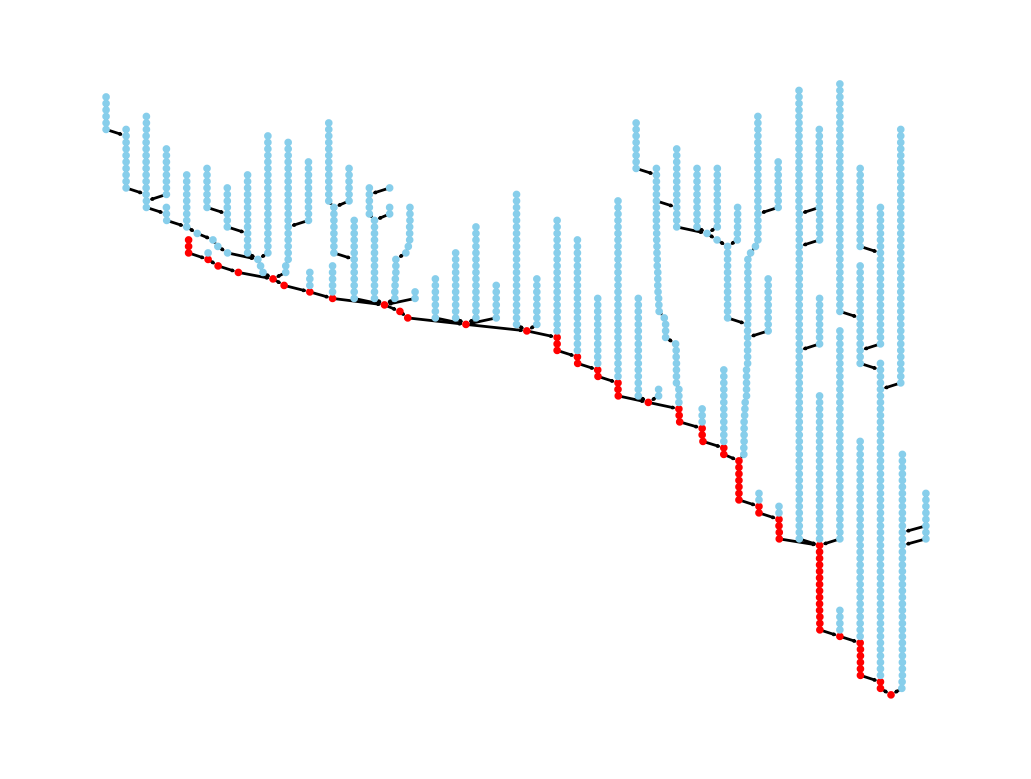

In [24]:
plot_tree(train_data)